# EYE FOR BLIND

### Capstone Project
#### Performed by - Rohit Lal

This notebook will be used to prepare the capstone project 'Eye for Blind'

In [1]:
#Import all the required libraries
import os
import re
import time
import glob
import pickle
import random
import operator
import datetime
import collections
from tqdm import tqdm
from collections import Counter
from nltk.translate.bleu_score import sentence_bleu

In [2]:
# numpy / pandas
import numpy as np
import pandas as pd

In [3]:
# sklearn
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from skimage import io
from PIL import Image

In [4]:
# matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [5]:
# tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import plot_model

In [6]:
tf.__version__

'2.2.0'

In [7]:
np.__version__

'1.19.2'

In [8]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

Let's read the dataset

## Data understanding
1.Import the dataset and read image & captions into two seperate variables

2.Visualise both the images & text present in the dataset

3.Create a dataframe which summarizes the image, path & captions as a dataframe

4.Create a list which contains all the captions & path

5.Visualise the top 30 occuring words in the captions



In [9]:
#Import the dataset and read the image into a seperate variable
input_dir = "dataset/"
image_dir = input_dir + 'Images/'
captions_txt = input_dir + 'captions.txt'
output_dir = "output/Images/"

all_images = glob.glob(image_dir + '/*.jpg', recursive=True)
print("The total images present in the dataset: {}".format(len(all_images)))

The total images present in the dataset: 8091


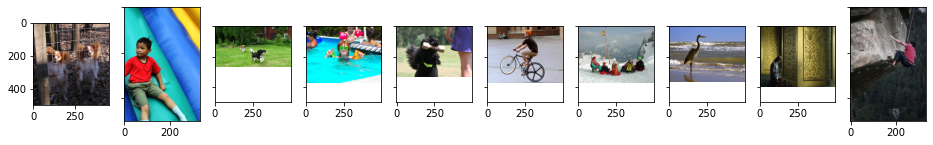

In [10]:
#Visualise both the images & text present in the dataset

def plot_images(images, cmap=None):
    
    fig, axis = plt.subplots(1, len(images), sharey=True)
    fig.set_figwidth(16)
   
    for ax, img in zip(axis, images):
        ax.imshow(io.imread(img), cmap)
        
#Plotting last 10 images 
plot_images(all_images[-10:])

In [11]:
def read_caption_text(captions_csv):
    return pd.read_csv(captions_csv)

captions_df = read_caption_text(captions_txt)
captions_df.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [12]:
# number of unique images & captions
captions_df.nunique()

image       8091
caption    40201
dtype: int64

We can see, each image having 5 captions in the dataset. Hence, `8091` images and `40201` captions

In [13]:
# print captions of last 2 images
captions_df.tail(10)

,image,caption
40445,997338199_7343367d7f.jpg,A person stands near golden walls .
40446,997338199_7343367d7f.jpg,a woman behind a scrolled wall is writing
40447,997338199_7343367d7f.jpg,A woman standing near a decorated wall writes .
40448,997338199_7343367d7f.jpg,The walls are covered in gold and patterns .
40449,997338199_7343367d7f.jpg,"Woman writing on a pad in room with gold , dec..."
40450,997722733_0cb5439472.jpg,A man in a pink shirt climbs a rock face
40451,997722733_0cb5439472.jpg,A man is rock climbing high in the air .
40452,997722733_0cb5439472.jpg,A person in a red shirt climbing up a rock fac...
40453,997722733_0cb5439472.jpg,A rock climber in a red shirt .
40454,997722733_0cb5439472.jpg,A rock climber practices on a rock climbing wa...


Create a dataframe which summarizes the image, path & captions as a dataframe

Each image id has 5 captions associated with it therefore the total dataset should have 40455 samples.

In [14]:
captions_df['ID'] = captions_df['image'].apply(lambda k: k.split('_')[0])
captions_df['Path'] = captions_df['image'].apply(lambda k: '{}{}'.format(image_dir, k))
captions_df.rename(columns={'caption': 'Captions'}, inplace=True)
captions_df = captions_df[['ID', 'Path', 'Captions']]
captions_df['Captions'] = captions_df['Captions'].str.lower()

In [15]:
# initializing variables
all_img_id = captions_df['ID']
all_img_path = captions_df['Path']
annotations = captions_df['Captions']

# max length of sequence
max_len = max(captions_df['Captions'].apply(lambda k : len(k.split())))

In [16]:
captions_df.head()

,ID,Path,Captions
0,1000268201,dataset/Images/1000268201_693b08cb0e.jpg,a child in a pink dress is climbing up a set o...
1,1000268201,dataset/Images/1000268201_693b08cb0e.jpg,a girl going into a wooden building .
2,1000268201,dataset/Images/1000268201_693b08cb0e.jpg,a little girl climbing into a wooden playhouse .
3,1000268201,dataset/Images/1000268201_693b08cb0e.jpg,a little girl climbing the stairs to her playh...
4,1000268201,dataset/Images/1000268201_693b08cb0e.jpg,a little girl in a pink dress going into a woo...


In [17]:
captions_df.index.size

40455

In [18]:
captions_df.nunique()

ID           8091
Path         8091
Captions    40170
dtype: int64

In [19]:
print("Total captions present in the dataset: "+ str(len(annotations)))
print("Total unique images present in the dataset: " + str(len(all_img_path.unique())))

Total captions present in the dataset: 40455
Total unique images present in the dataset: 8091


#### Plotting both images & captions side-by-side

In [20]:
def plot_img_with_caption(img, captions, fig, count, num_imgs=5):
    
    # plot image
    ax = fig.add_subplot(num_imgs, 2, count)
    plt.axis('off')
    ax.imshow(img)
    count +=1
    
    # plot captions
    ax = fig.add_subplot(num_imgs, 2, count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,len(captions))
    for i, caption in enumerate(captions):
        ax.text(0,i,caption,fontsize=20)

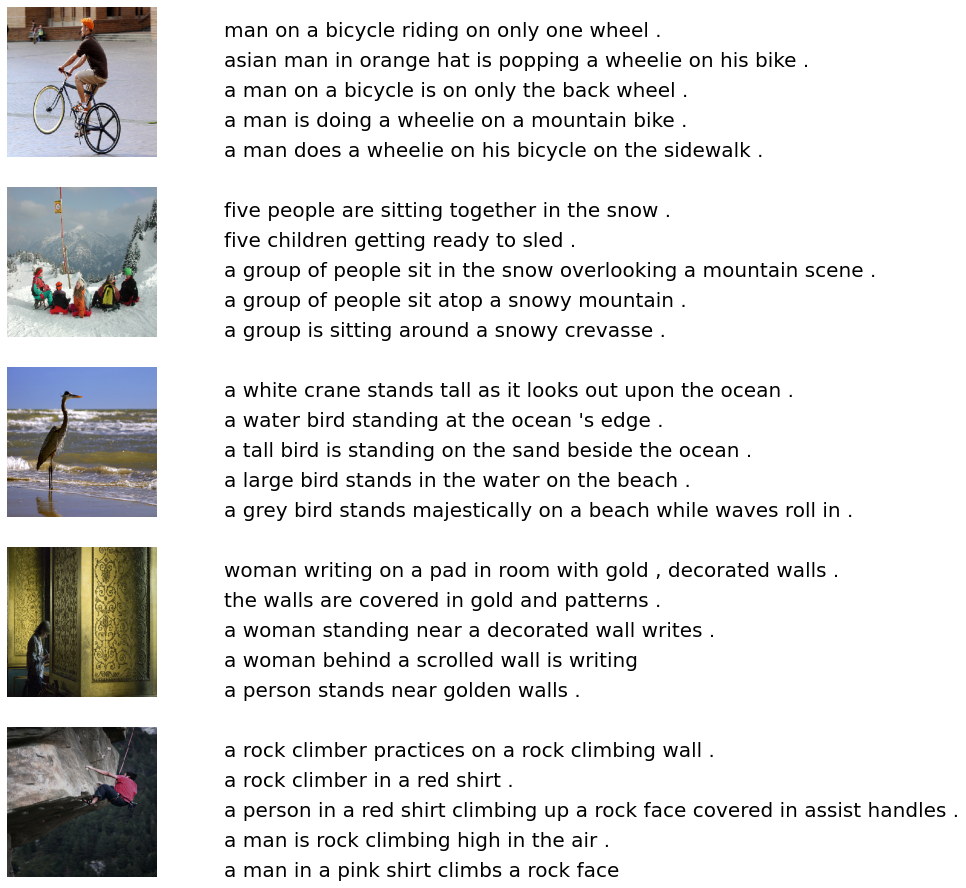

In [21]:
fig = plt.figure(figsize=(8,16))
count = 1
    
for img_path in captions_df[-25:]['Path'].unique():
    img = load_img(img_path, target_size = (299,299,3))
    captions = captions_df[captions_df['Path'] == img_path]['Captions'].values
    plot_img_with_caption(img, captions, fig, count)
    count +=2
plt.show()

In [22]:
# Create the vocabulary & the counter for the captions

# function to split the caption into individual words
def split_caption(caption):
    return list(filter(lambda x: len(x) > 0, re.split('\W+', caption.lower())))

# function to create a vacabulary
def create_vocab(captions):
      
    all_words = []
    
    for each_caption in captions:
        words = split_caption(each_caption)
        for each_word in words: 
            all_words.append(each_word)
    
    all_words = sorted(all_words)
    return all_words

In [23]:
# creating a vocabulary
vocabulary = create_vocab(annotations)

In [ ]:
# creating counter
vocabulary_count = Counter(vocabulary)

In [24]:
# Building dataframe of the counter.
vocab_df = pd.DataFrame.from_dict(vocabulary_count, orient='index').reset_index()
vocab_df.columns = ['word', 'count']
vocab_df = vocab_df.sort_values(by=['count'], ascending=False)

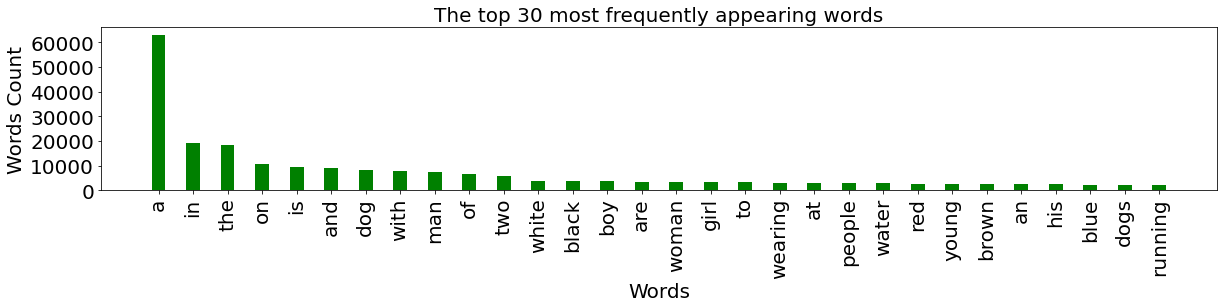

In [25]:
# Visualise the top 30 occuring words in the captions
def plot_hist(df, title="The top 30 most frequently appearing words"):
    
    df = df.reset_index()
    plt.figure(figsize=(20,3))
    
    plt.bar(df['word'], df['count'], color='green', width=0.4)
    plt.xlabel("Words",  fontsize=20) 
    plt.ylabel("Words Count", rotation=90, fontsize=20) 
    plt.yticks(fontsize=20)
    plt.xticks(df.index, df['word'], rotation=90, fontsize=20)
    plt.title(title, fontsize=20)
    plt.show()

plot_hist(vocab_df[:30])

In [26]:
# adding the <start> & <end> token to all those captions
captions_df['Captions'] = captions_df['Captions'].apply(lambda k : '<start> {} <end>'.format(k))

## Pre-Processing the captions
1.Create the tokenized vectors by tokenizing the captions fore ex :split them using spaces & other filters. 
This gives us a vocabulary of all of the unique words in the data. Keep the total vocaublary to top 5,000 words for saving memory.

2.Replace all other words with the unknown token "UNK" .

3.Create word-to-index and index-to-word mappings.

4.Pad all sequences to be the same length as the longest one.

In [27]:
# shuffle data

img_captions, all_img_path = shuffle(annotations, all_img_path, random_state=42)
# img_captions, all_img_vector = annotations, all_img_path

In [ ]:
# function to create the tokenizer
def tokenize_captions(top_freq_words, captions):
    
    special_chars = '!"#$%&()*+.,-/:;=?@[\]^_`{|}~ '
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=top_freq_words,
        oov_token="UNK",
        filters=special_chars
    )
    tokenizer.fit_on_texts(captions)
    
    # Add padding
    tokenizer.word_index['PAD'] = 0
    tokenizer.index_word[0] = 'PAD'   
   
    return tokenizer  

In [28]:
# Create the tokenized vectors
top_freq_words = 5000
tokenizer = tokenize_captions(top_freq_words, img_captions)

In [29]:
cap_seqs = tokenizer.texts_to_sequences(img_captions)

In [30]:
# Pad each vector to the max_length of the captions
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(cap_seqs, padding='post')

In [31]:
print("The shape of Caption vector is :" + str(cap_vector.shape))
cap_vector[:5]

The shape of Caption vector is :(40455, 39)


array([[   3,    2,   56, 1638,  589,    8, 4084,    2,  228,  125,    2,
        1449,    4,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0],
       [   3,   14,   28,   32,  509,    7,    6, 1503,  171,    4,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0],
       [   3,    2,   12,    5,  161,    8,   39,    7,    2,   86,   90,
          85,   23,    6,  478,   76,    6, 4085,    4,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0],
       [   3,    2,  900,   15,   10,    8,   33,    7,    6,   42,    4,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,  

In [32]:
# Max length of sequence 
max_length = max([len(cap) for cap in cap_seqs])
print("The shape of Caption vector is :" + str(cap_vector.shape))
print("Maximium length of sequence = ", max_length)

The shape of Caption vector is :(40455, 39)
Maximium length of sequence =  39


In [33]:
# Create word-to-index and index-to-word mappings.
def word_to_index_mapping(word):
    return f'Word = {word}, Index = {tokenizer.word_index[word]}'

def index_to_word_mapping(index):
    return f'Index = {index}, Word = {tokenizer.index_word[index]}'         

In [34]:
print(word_to_index_mapping("<end>"))
print(word_to_index_mapping("PAD"))

Word = <end>, Index = 4
Word = PAD, Index = 0


In [35]:
print(index_to_word_mapping(10))
print(index_to_word_mapping(5999))

Index = 10, Word = dog
Index = 5999, Word = sewer


In [36]:
# Create a word count of your tokenizer to visulize the Top 30 occuring words after text processing

word_count = tokenizer.word_counts
word_count = sorted(word_count.items(), key=operator.itemgetter(1),reverse=True)

for k,v in word_count[:30]:
    print(k,v)

a 62992
<start> 40455
<end> 40455
in 18986
the 18419
on 10745
is 9345
and 8862
dog 8138
with 7765
man 7274
of 6723
two 5642
white 3959
black 3848
boy 3581
are 3504
woman 3402
girl 3328
to 3176
wearing 3062
at 2915
people 2883
water 2790
red 2691
young 2630
brown 2578
an 2432
his 2357
blue 2279


## Pre-processing the images

1.Resize them into the shape of (299, 299)

3.Normalize the image within the range of -1 to 1, such that it is in correct format for InceptionV3. 

### FAQs on how to resize the images::
* Since you have a list which contains all the image path, you need to first convert them to a dataset using <i>tf.data.Dataset.from_tensor_slices</i>. Once you have created a dataset consisting of image paths, you need to apply a function to the dataset which will apply the necessary preprocessing to each image. 
* This function should resize them and also should do the necessary preprocessing that it is in correct format for InceptionV3.


In [37]:
#write your code here for creating the function. This function should return images & their path

def load_image(image_path):
    #write your pre-processing steps here
    shape = (299, 299)
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image,channels=3)
    image = tf.image.resize(image,shape)
    image = tf.keras.applications.inception_v3.preprocess_input(image)
    return image, image_path

In [38]:
# write your code here for applying the function to the image path dataset, such that the transformed dataset should contain images & their path

BATCH_SIZE = 64
shape = (299, 299)
encode = sorted(all_img_path.unique())

image_dataset = tf.data.Dataset.from_tensor_slices(encode)
image_dataset = image_dataset.map(
    load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(64)

In [39]:
sample_img_batch, sample_cap_batch = next(iter(image_dataset))
print(sample_img_batch.shape)
print(sample_cap_batch.shape)

(64, 299, 299, 3)
(64,)


## Load the pretrained Imagenet weights of Inception net V3

1.To save the memory(RAM) from getting exhausted, extract the features of the images using the last layer of pre-trained model. Including this as part of training will lead to higher computational time.

2.The shape of the output of this layer is 8x8x2048. 

3.Use a function to extract the features of each image in the train & test dataset such that the shape of each image should be (batch_size, 8*8, 2048)



In [40]:
image_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

### FAQs on how to store the features:
* You can store the features using a dictionary with the path as the key and values as the feature extracted by the inception net v3 model OR
* You can store using numpy(np.save) to store the resulting vector.

## Dataset creation
1.Apply train_test_split on both image path & captions to create the train & test list. Create the train-test spliit using 80-20 ratio & random state = 42

2.Create a function which maps the image path to their feature. 

3.Create a builder function to create train & test dataset & apply the function created earlier to transform the dataset

2.Make sure you have done Shuffle and batch while building the dataset

3.The shape of each image in the dataset after building should be (batch_size, 8*8, 2048)

4.The shape of each caption in the dataset after building should be(batch_size, max_len)


In [41]:
# dividing data into test-train split - 80 /20 ratio
img_train, img_test, cap_train, cap_test = train_test_split(all_img_path, cap_vector, test_size=0.2, random_state=42)

In [42]:
print("Training data for images: " + str(len(img_train)))
print("Testing data for images: " + str(len(img_test)))
print("Training data for Captions: " + str(len(cap_train)))
print("Testing data for Captions: " + str(len(cap_test)))

Training data for images: 32364
Testing data for images: 8091
Training data for Captions: 32364
Testing data for Captions: 8091


In [43]:
all_img_np = []

for img, path in tqdm(image_dataset):
    batch_features = image_features_extract_model(img)
    batch_features = tf.reshape(
        batch_features, (batch_features.shape[0], -1, batch_features.shape[3]))
    
    for batch_feature, im_path in zip(batch_features, path):
        f_name = im_path.numpy().decode("utf-8").split('/')[-1]
        all_img_np.append(f_name)
        np.save(output_dir + f_name, batch_feature.numpy())

127it [01:34,  1.34it/s]


In [44]:
print("Total images present in dataset: {}".format(len(all_img_np)))
print(all_img_np[0])

Total images present in dataset: 8091
1000268201_693b08cb0e.jpg


In [45]:
img_to_cap_vector = collections.defaultdict(list)

for img, cap in zip(all_img_path, cap_vector):
    img_to_cap_vector[img].append(cap)

In [46]:
# settting random seed to 42
tf.random.set_seed(42)
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_idx = int(len(img_keys) * 0.8)
image_name_train_keys, image_name_val_keys = img_keys[:slice_idx], img_keys[slice_idx:]

In [47]:
# preparing train data
img_train = []
cap_train = []

for img in image_name_train_keys:
    img_train.extend([img] * len(img_to_cap_vector[img]))
    cap_train.extend(img_to_cap_vector[img])

In [48]:
# preparing test data
img_test = []
cap_test = []

for img in image_name_val_keys:
    img_test.extend([img] * len(img_to_cap_vector[img]))
    cap_test.extend(img_to_cap_vector[img])

In [49]:
print("Image_train = {}, Captions_train = {}".format(len(img_train), len(cap_train)))
print("Image_test = {}, Captions_test = {}".format(len(img_test), len(cap_test)))

Image_train = 32360, Captions_train = 32360
Image_test = 8095, Captions_test = 8095


In [50]:
def get_file_path(f_name):
    return (image_dir + f_name)

def convert_vector_to_sentence(captions_list):
    captions_word =[]
    for captions in captions_list:
        list_caption = list(captions)
        captions_word.append(' '.join(tokenizer.index_word[i] for i in list_caption))
    return captions_word

In [51]:
captions_list = []
captions_word = convert_vector_to_sentence(list(cap_train[0:30]))
print(captions_word[25])
print(captions_word[26])

<start> the little girl a striped shirt jumped out of a swing <end> PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD
<start> a young girl jumps off her swing in front of building <end> PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD


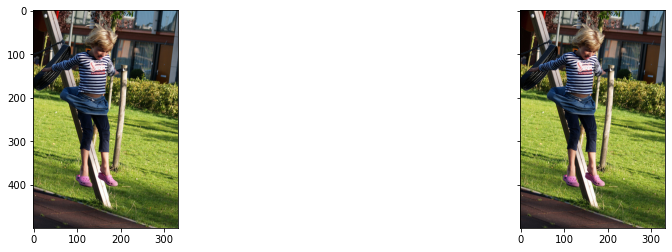

In [52]:
plot_images([
    img_train[25],
    img_train[26]])

In [53]:
# Create a function which maps the image path to their feature. 
# This function will take the image_path & caption and return it's feature & respective caption.
    
def map_func(img_name, caption):
    f_name = output_dir + img_name.decode('utf-8').split('/')[-1] + ".npy"
    img_tensor = np.load(f_name)
    return img_tensor, cap

### FAQs on how to load the features:
* You can load the features using the dictionary created earlier OR
* You can store using numpy(np.load) to load the feature vector.

In [54]:
# create a builder function to create dataset which takes in the image path & captions as input
# This function should transform the created dataset(img_path,cap) to (features,cap) using the map_func created earlier

def gen_dataset(dataset_images, dataset_captions, batch_size, buffer_size):
    
    # your code goes here to create the dataset & transform it
    dataset = tf.data.Dataset.from_tensor_slices((dataset_images, dataset_captions))
    
    # Use map to load the numpy files in parallel
    dataset = dataset.map(lambda item1, item2: tf.numpy_function(
        map_func, [item1, item2], [tf.float32, tf.int32]), num_parallel_calls=tf.data.experimental.AUTOTUNE)

    # Shuffle and batch
    dataset = dataset.shuffle(buffer_size).batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    
    return dataset

In [55]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000

In [56]:
# generating train dataset
train_dataset=gen_dataset(img_train, cap_train, batch_size=BATCH_SIZE, buffer_size=BUFFER_SIZE)

In [57]:
# generating test dataset
test_dataset=gen_dataset(img_test, cap_test, batch_size=BATCH_SIZE, buffer_size=BUFFER_SIZE)

In [58]:
train_img_batch, train_cap_batch = next(iter(train_dataset))
print(train_img_batch.shape)  #(batch_size, 8*8, 2048)
print(train_cap_batch.shape) #(batch_size,max_len)

(64, 64, 2048)
(64, 39)


In [59]:
test_img_batch, test_cap_batch = next(iter(test_dataset))
print(test_img_batch.shape)  #(batch_size, 8*8, 2048)
print(test_cap_batch.shape) #(batch_size,max_len)

(64, 64, 2048)
(64, 39)


## Model Building
1.Set the parameters

2.Build the Encoder, Attention model & Decoder

In [60]:
embedding_dim = 256 
units = 512
vocab_size = top_freq_words + 1 #top 5,000 words +1
train_num_steps = len(img_train) // BATCH_SIZE
test_num_steps = len(img_test) // BATCH_SIZE

# InceptionV3 Feature Vector shape - (64, 2048)
features_shape = 2048
attention_features_shape = 64

#### Utility functions

In [63]:
def scaled_dot_product_attention(w1, w2, v, mask):
    matmul_w1w2 = tf.matmul(w1, w2, transpose_b=True)
    dim_w2 = tf.cast(tf.shape(w2)[-1], tf.float32)
    scaled_attention_logits = matmul_w1w2/ tf.math.sqrt(dim_w2)

    if mask is not None:
        scaled_attention_logits += (mask * -1e9) 

    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1) 
    output = tf.matmul(attention_weights, v)

    return output, attention_weights

# mask for padding
def padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    # return shape - (batch_size, 1, 1, seq_len)
    return seq[:, tf.newaxis, tf.newaxis, :]  

def look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    # return shape - (seq_len, seq_len)
    return mask

### Encoder

In [63]:
class Encoder(Model):
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        #build your Dense layer with relu activation
        self.dense = tf.keras.layers.Dense(embedding_dim)
        
    def call(self, features):
        # extract the features from the image shape: (batch, 8*8, embed_dim)
        features = self.dense(features)
        features = tf.nn.relu(features)
        return features

In [64]:
encoder=Encoder(embedding_dim)

### Attention model

In [65]:
class Attention_model(Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 = tf.keras.layers.Dense(units) # build your Dense layer
        self.W2 = tf.keras.layers.Dense(units) # build your Dense layer
        self.V = tf.keras.layers.Dense(1) # build your final Dense layer with unit 1
        self.units=units

    def call(self, features, hidden):
        #features shape: (batch_size, 8*8, embedding_dim)
        # hidden shape: (batch_size, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden,1) # Expand the hidden shape to shape: (batch_size, 1, hidden_size)
        attention_hidden_layer = (tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis)))
        score = self.V(attention_hidden_layer) # build your score funciton to shape: (batch_size, 8*8, units)
        attention_weights =  tf.nn.softmax(score,axis=1) # extract your attention weights with shape: (batch_size, 8*8, 1)
        context_vector = attention_weights * features  # shape: create the context vector with shape (batch_size, 8*8,embedding_dim)
        context_vector = tf.reduce_sum(context_vector,axis=1) # reduce the shape to (batch_size, embedding_dim)

        return context_vector, attention_weights

### Decoder

In [66]:
class Decoder(Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units
        self.attention = Attention_model(self.units) # iniitalise your Attention model with units
        self.embed = tf.keras.layers.Embedding(vocab_size,embed_dim) # build your Embedding layer
        self.gru = tf.keras.layers.GRU(self.units, return_sequences=True, return_state=True, 
                                       recurrent_initializer='glorot_uniform')
        self.d1 = tf.keras.layers.Dense(self.units) # build your Dense layer
        self.d2 = tf.keras.layers.Dense(vocab_size) # build your Dense layer
        self.attention = Attention_model(self.units)
        
        

    def call(self,x,features, hidden):
        
        # create your context vector & attention weights from attention model
        context_vector, attention_weights = self.attention(features,hidden)
        # embed your input to shape: (batch_size, 1, embedding_dim)
        embed =  self.embed(x)
        # Concatenate your input with the context vector from attention layer. Shape: (batch_size, 1, embedding_dim + embedding_dim)
        embed =  tf.concat([tf.expand_dims(context_vector,1),embed],axis=-1)
        # Extract the output & hidden state from GRU layer. Output shape : (batch_size, max_length, hidden_size)
        output,state = self.gru(embed)
        x = self.d1(output)
        x = tf.reshape(x, (-1, x.shape[2])) # shape : (batch_size * max_length, hidden_size)
        x = self.d2(x) # shape : (batch_size * max_length, vocab_size)
        
        return x, state, attention_weights
    
    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [67]:
decoder=Decoder(embedding_dim, units, vocab_size)

In [68]:
features=encoder(train_img_batch)

hidden = decoder.init_state(batch_size=train_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * train_cap_batch.shape[0], 1)

predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape)) #(batch, 8*8, embed_dim)
print('Predcitions shape from Decoder: {}'.format(predictions.shape)) #(batch,vocab_size)
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape)) #(batch, 8*8, embed_dim)

Feature shape from Encoder: (64, 64, 256)
Predcitions shape from Decoder: (64, 5001)
Attention weights shape from Decoder: (64, 64, 1)


In [69]:
class final_Model(tf.keras.Model):
    def __init__(self, embedding_dim,units,vocab_size, rate=0.1):
        super(final_Model, self).__init__()
        self.encoder = Encoder(embedding_dim) # d_model, num_heads, dff,row_size,col_size, rate)
        self.decoder = Decoder(embedding_dim, units, vocab_size)
        self.final_layer = tf.keras.layers.Dense(vocab_size)

    def call(self, inp, tar, training,look_ahead_mask=None,dec_padding_mask=None,enc_padding_mask=None   ):
        enc_output = self.encoder(embeding_dim)  # (batch_size, inp_seq_len, d_model      )
        dec_output, attention_weights = self.decoder(embeding_dim,units,vocab_size)
        final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)
        return final_output, attention_weights

## Model training & optimization
1.Set the optimizer & loss object

2.Create your checkpoint path

3.Create your training & testing step functions

4.Create your loss function for the test dataset

In [70]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
    
learning_rate = CustomSchedule(embedding_dim)

In [71]:
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
metric = tf.keras.metrics.Mean('train_loss',dtype=tf.float32)

In [72]:
optimizer = tf.keras.optimizers.Adam()

In [73]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [74]:
ckpt_path = "checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder, decoder=decoder, optimizer = optimizer, metrics=metric)
ckpt_manager = tf.train.CheckpointManager(ckpt, ckpt_path, max_to_keep=5)

In [75]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    ckpt.restore(ckpt_manager.latest_checkpoint)

* While creating the training step for your model, you will apply Teacher forcing.
* Teacher forcing is a technique where the target/real word is passed as the next input to the decoder instead of previous prediciton.

In [76]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
    with tf.GradientTape() as tape:
        #write your code here to do the training steps
        features = encoder(img_tensor,training =True)

        for i in range(1, target.shape[1]):
          # passing the features through the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)

            loss += loss_function(target[:, i], predictions)

          # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)
            
    avg_loss = (loss / int(target.shape[1]))
    trainable_variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, trainable_variables)
    
    optimizer.apply_gradients(zip(gradients, trainable_variables))
    metric(loss)
    
    return loss, avg_loss

* While creating the test step for your model, you will pass your previous prediciton as the next input to the decoder.

In [77]:
@tf.function
def test_step(img_tensor, target):
    loss = 0
    
    #write your code here to do the testing steps
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    features = encoder(img_tensor)
    
    for i in range(1, target.shape[1]):
          
        # passing the features through the decoder
        predictions, hidden, _ = decoder(dec_input, features, hidden)

        loss += loss_function(target[:, i], predictions)
        predicted_id = tf.argmax(predictions[0])
        dec_input = tf.expand_dims([predicted_id] * target.shape[0] , 1)

    avg_loss = (loss / int(target.shape[1]))
        
    return loss, avg_loss

In [78]:
def test_loss_cal(dataset):
    total_loss = 0

    #write your code to get the average loss result on your test data
    for (batch,(img_tensor,target)) in enumerate(dataset):
        batch_loss, t_loss = test_step(img_tensor, target)
        total_loss += t_loss
        
    avg_test_loss = total_loss/int(target.shape[1])
    
    return avg_test_loss

In [79]:
train_loss = tf.keras.metrics.Mean('train_loss',dtype=tf.float32)

In [80]:
train_loss_plot = []
test_loss_plot = []
EPOCHS = 8

best_test_loss=100
for epoch in tqdm(range(0, EPOCHS)):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        
    avg_train_loss=total_loss / train_num_steps
    train_loss_plot.append(avg_train_loss)
    
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)
    
    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()

 12%|█▎        | 1/8 [05:22<37:34, 322.09s/it]

For epoch: 1, the train loss is 1.597, & test loss is 7.782
Time taken for 1 epoch 321.8904666900635 sec

Test loss has been reduced from 100.000 to 7.782


 25%|██▌       | 2/8 [08:52<25:37, 256.30s/it]

For epoch: 2, the train loss is 0.063, & test loss is 12.840
Time taken for 1 epoch 210.2409987449646 sec



 38%|███▊      | 3/8 [12:20<19:31, 234.30s/it]

For epoch: 3, the train loss is 0.003, & test loss is 0.118
Time taken for 1 epoch 207.9477198123932 sec

Test loss has been reduced from 7.782 to 0.118


 50%|█████     | 4/8 [15:48<14:55, 223.76s/it]

For epoch: 4, the train loss is 0.001, & test loss is 0.094
Time taken for 1 epoch 207.40931153297424 sec

Test loss has been reduced from 0.118 to 0.094


 62%|██████▎   | 5/8 [19:19<10:57, 219.19s/it]

For epoch: 5, the train loss is 0.000, & test loss is 0.003
Time taken for 1 epoch 210.89397478103638 sec

Test loss has been reduced from 0.094 to 0.003


 75%|███████▌  | 6/8 [22:46<07:10, 215.24s/it]

For epoch: 6, the train loss is 0.000, & test loss is 0.003
Time taken for 1 epoch 207.40554451942444 sec

Test loss has been reduced from 0.003 to 0.003


 88%|████████▊ | 7/8 [26:13<03:32, 212.51s/it]

For epoch: 7, the train loss is 0.000, & test loss is 0.143
Time taken for 1 epoch 206.8748161792755 sec

For epoch: 8, the train loss is 0.000, & test loss is 0.001
Time taken for 1 epoch 211.88806986808777 sec

Test loss has been reduced from 0.003 to 0.001


100%|██████████| 8/8 [29:45<00:00, 223.21s/it]


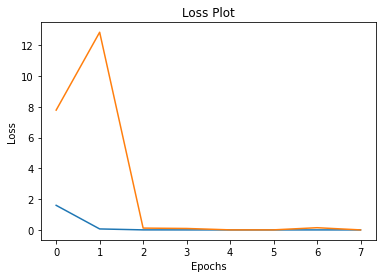

In [81]:
plt.plot(train_loss_plot)
plt.plot(test_loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

#### NOTE: 
* Since there is a difference between the train & test steps ( Presence of teacher forcing), you may observe that the train loss is decreasing while your test loss is not. 
* This doesn't mean that the model is overfitting, as we can't compare the train & test results here, as both approach is different.
* Also, if you want to achieve better results you can run it more epochs, but the intent of this capstone is to give you an idea on how to integrate attention mechanism with E-D architecture for images. The intent is not to create the state of art model. 

## Model Evaluation
1.Define your evaluation function using greedy search

2.Define your evaluation function using beam search ( optional)

3.Test it on a sample data using BLEU score

### Greedy Search

In [92]:
def greedy_evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0) #process the input image to desired format before extracting features    
    img_tensor_val = image_features_extract_model(temp_input) # Extract features using our feature extraction model
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val) # extract the features by passing the input to encoder 

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,features,hidden) # get the output from decoder

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy() # extract the predicted id(embedded value) which carries the max value
        
        #map the id to the word from tokenizer and append the value to the result list
        result.append(tokenizer.index_word[predicted_id])
        
        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot,predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot, predictions


### Beam Search(optional)

In [93]:
def beam_evaluate(image, beam_index = 3):

    #write your code to evaluate the result using beam search
    start = [tokenizer.word_index["<start>"]]
    result = [[start, 0.0]]
                  
    attention_plot = np.zeros((max_length,attention_features_shape))  
    hidden = decoder.init_state(batch_size=1)
    
    temp_input = tf.expand_dims(load_image(image)[0], 0) #process the input image to desired format before extracting features
    img_tensor_val = image_features_extract_model(temp_input)# Extract features using our feature extraction model
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))
    features = encoder(img_tensor_val)# extract the features by passing the input to encoder
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    
    while len(result[0][0]) < max_length:
        i = 0 
        temp = []
        for s in result:
            preds, hidden, attention_weights = decoder(dec_input,features,hidden)
            attention_plot = tf.reshape(attention_weights,(-1,)).numpy()
            i +=1
            # Getting the top <beam_index>(n) predictions and creating a 
            word_preds = np.argsort(preds[0])[-beam_index:]
            
            
            # new list  to put in the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        result = temp
        # Sorting according to the probabilities
        result = sorted(result, reverse=False, key=lambda l: l[1])
        # Getting the top words
        result = result[-beam_index:]
        predicted_id = result[-1]
        pred_list = predicted_id[0]
        
        pred_id = pred_list[-1]       
        if(pred_id ==3):
            break            
                  
        dec_input = tf.expand_dims([pred_id],0)
    
    result = result[-1][0]
    intermediate_caption = [tokenizer.index_word[i] for i in result]

    final_caption = []
    
    for i in intermediate_caption:
        if i == '<end>':
            break
        final_caption.append(i)
        
    attention_plot = attention_plot[:len(result),:]
    final_caption = ' '.join(final_caption[1:])
                  
    return final_caption, attention_plot      

In [94]:
def plot_attmap(caption, weights, image):

    fig = plt.figure(figsize=(10, 10))
    temp_img = np.array(Image.open(image))
    
    len_cap = len(caption)
    for cap in range(len_cap):
        weights_img = np.reshape(weights[cap], (8,8))
        weights_img = np.array(Image.fromarray(weights_img).resize((224, 224), Image.LANCZOS))
        
        ax = fig.add_subplot(len_cap//2, len_cap//2, cap+1)
        ax.set_title(caption[cap], fontsize=15)
        
        img=ax.imshow(temp_img)
        
        ax.imshow(weights_img, cmap='gist_heat', alpha=0.6,extent=img.get_extent())
        ax.axis('off')
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()

In [95]:
def filt_text(text):
    filt=['<start>','<unk>','<end>'] 
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

In [96]:
rid = np.random.randint(0, len(img_test))
test_image = img_test[rid]

real_caption = ' '.join([tokenizer.index_word[i] for i in cap_test[rid] if i not in [0]])
result, attention_plot, pred_test = greedy_evaluate(test_image)

In [97]:
real_caption=filt_text(real_caption)      
pred_caption=' '.join(result).rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()

In [98]:
score = sentence_bleu(reference, candidate, weights=(0,0,1,0))
print(f"BELU score: {score*100}")

BELU score: 2.2250738585072627e-306


/home/admin/.conda/envs/tf20/lib/python3.8/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/admin/.conda/envs/tf20/lib/python3.8/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


In [99]:
print ('Real Caption:', real_caption)
print ('Prediction Caption:', pred_caption)                      

Real Caption: two adults and a child wait to cross a street
Prediction Caption: a group of young people pose for a group photo


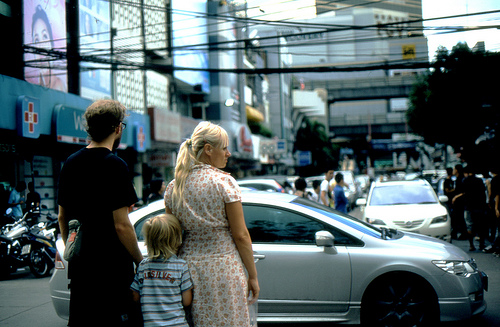

In [101]:
Image.open(test_image)

### Observations / Results -

- **Training loss and both validation loss is reducing as the epochs increasing, which shows model is learning.**

- **Greedy search, Beam Search & BLEU Score were used for model evaluation.**

- **Even when model is trained on just 8 epochs, we can see it has some understaning of context.**
- ***In the test image, the model is able to detect there is group of people and frames the caption according to it.***

- **The accuracy of the model can be further improved by training on more number of epochs for longer time.**